# VQ - VAE MNIST

This notebook is for implementing Discrete Latent Learning from the paper 
[Neural Discrete Representation Learning](https://arxiv.org/abs/1711.00937) with [Tensorflow](https://www.tensorflow.org/).

[Mnist Dataset](http://yann.lecun.com/exdb/mnist/) dataset, which is 128x128 size, will be used.

Reference : [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections), [jiazhao97's Github](https://github.com/jiazhao97/VQ-VAE_withPixelCNNprior)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

# Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from sklearn.utils import shuffle
import cv2
import glob
import datetime
from tensorflow.examples.tutorials.mnist import input_data

# Parameters

In [3]:
algorithm = 'VQVAE'

num_epoch  = 20

learning_rate=3e-4
commitment_loss=0.25

gpu_fraction = 0.9

image_size = 28
num_channel = 1
batch_size = 100
num_hiddens = 64
num_residual_hiddens = 16
num_residual_layers = 2

K=8
D=16

num_epoch_pixel=50
num_layers_pixelcnn=12

fmaps_pixelcnn=32
learning_rate_pixelcnn=1e-3
grad_clip_pixelcnn=1.0

load_model = False
train_model = True

save_path = "./saved_models/VQVAE+PixelCNN"

# Import Mnist Dataset

In [ ]:
mnist=input_data.read_data_sets('dataset/mnist',reshape=False)

X_train=mnist.train.images
X_train=np.reshape(X_train,[len(X_train),image_size,image_size,1])
data_variance = np.var(X_train)

X_train=(X_train-0.5)/0.5

print("Mnist dataset Length: {}".format(len(X_train)))

# VQ-VAE Network

In [5]:
def ResNet(x, is_training, network_name):
    
    h = tf.layers.conv2d(x, filters=64, kernel_size=3, strides=1, padding='SAME',
                         name=network_name+'_R1')
    h = tf.contrib.layers.instance_norm(h)
    h = tf.nn.relu(h)
    h = tf.layers.conv2d(h, filters=64, kernel_size=3, strides=1, padding='SAME',
                         name=network_name+'_R2')
    h = tf.contrib.layers.instance_norm(h)
    h = x + h 
    h = tf.nn.relu(h)
    
    return h

def Encoder(x, is_training, reuse=False):
    with tf.variable_scope('encoder', reuse=reuse):
        
        e1=tf.layers.conv2d(x, filters=32, kernel_size=4, strides=2, padding='SAME')
        e1=tf.contrib.layers.instance_norm(e1)
        e1=tf.nn.relu(e1)
        
        e2=tf.layers.conv2d(e1, filters=64, kernel_size=4, strides=2, padding='SAME')
        e2=tf.contrib.layers.instance_norm(e2)
        e2=tf.nn.relu(e2)
        
        e3=tf.layers.conv2d(e2, filters=64, kernel_size=3, strides=1, padding='SAME')
        e3=tf.contrib.layers.instance_norm(e3)
        e3=tf.nn.relu(e3)
        
        e4=ResNet(e3,is_training, 'encoder'+'r1')
        e5=ResNet(e4,is_training, 'encoder'+'r2')
        
        e6=tf.layers.conv2d(e5, filters=D, kernel_size=1, strides=1, padding='SAME')
    
    return e6

def Decoder(x, is_training, reuse=False):
    
    with tf.variable_scope('decoder', reuse=reuse):
        
        d0 = tf.layers.conv2d(x,filters=64, kernel_size=3, strides=1, padding='SAME')
        d0 = tf.nn.relu(d0)
        
        d1=ResNet(d0, is_training, 'decoder'+ 'r1')      
        d2=ResNet(d1, is_training, 'decoder'+ 'r2')
                   
        d3 = tf.layers.conv2d_transpose(d2,filters=32, kernel_size=4, strides=2, padding='SAME')
        d3 = tf.contrib.layers.instance_norm(d3)
        d3 = tf.nn.relu(d3)
               
        output = tf.layers.conv2d_transpose(d3, filters=1, activation=tf.tanh,
                                            kernel_size=4, strides=2, padding='SAME')
   
        return output


def VQ(x, beta, pixel_sample=None, pixel_flag=False):
    
    
    with tf.variable_scope('VQ', reuse=tf.AUTO_REUSE):
        embd_space=tf.get_variable(name='embd_space',shape=[D,K], 
                                   initializer=tf.uniform_unit_scaling_initializer())
    
    
    if pixel_flag:
        pixel_sample=tf.reshape(pixel_sample, shape=[-1, 7, 7])
        pixel_sample = tf.cast(pixel_sample, tf.int32)
        vq_ind=pixel_sample
    
    else:
        matrix=tf.zeros([tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], 1])

        for i in range(K):

            embd_i=tf.reshape(embd_space[:,i], [1,1,1,D])
            embd_cal=tf.tile(embd_i, multiples=[tf.shape(x)[0], tf.shape(x)[1],tf.shape(x)[2],1])
            mat=tf.reshape(tf.reduce_sum(tf.square(tf.add(x,-embd_cal)),3),
                           [tf.shape(x)[0], tf.shape(x)[1],tf.shape(x)[2],1])
            matrix=tf.concat([matrix,mat],3)

        vq_ind=tf.argmin(matrix[:,:,:,1:K],3)
        vq_ind=tf.cast(vq_ind, tf.int32)
    

    rand_ind = tf.random_uniform(tf.shape(vq_ind), minval=0, maxval=1)
    rand_ind = tf.floor(rand_ind * K)
    rand_ind = tf.clip_by_value(rand_ind, 0, K-1)
    rand_ind = tf.cast(rand_ind, tf.int32)

    rand_zq=tf.nn.embedding_lookup(tf.transpose(embd_space), rand_ind)
    
    zq=tf.nn.embedding_lookup(tf.transpose(embd_space), vq_ind)
        
    embd_vq_loss=tf.reduce_mean((tf.stop_gradient(zq)-x)**2)
    enc_vq_loss=tf.reduce_mean((zq-tf.stop_gradient(x))**2)
    
    loss=embd_vq_loss+enc_vq_loss*beta
    
    zq=x+tf.stop_gradient(zq-x)    
    
    return vq_ind, zq, rand_zq, loss
    

# PixelCNN Network

Reference: [jiazhao97's Github](https://github.com/jiazhao97/VQ-VAE_withPixelCNNprior)

In [6]:
def get_weights_pixelcnn(shape, name, horizontal=False, mask=None):
    
    weights_initializer = tf.contrib.layers.xavier_initializer()
    W = tf.get_variable(name=name, shape=shape, dtype=tf.float32, initializer=weights_initializer)
    if mask:
        filter_mid_y = shape[0]//2
        filter_mid_x = shape[1]//2
        mask_filter = np.ones(shape=shape, dtype=np.float32)

        if horizontal: 
            mask_filter[filter_mid_y+1:, :, :, :] = 0.0
            mask_filter[filter_mid_y, filter_mid_x+1:, :, :] = 0.0
            if mask == 'a':
                mask_filter[filter_mid_y, filter_mid_x, :, :] = 0.0
        else: 
            if mask == 'a':
                mask_filter[filter_mid_y:, :, :, :] = 0.0
            else:
                mask_filter[filter_mid_y+1:, :, :, :] = 0.0
        W *= mask_filter

    return W

def gated_conv_pixelcnn(W_shape_f, fan_in, horizontal, payload=None, mask=None):

    in_dim = fan_in.get_shape()[-1]
    W_shape = [W_shape_f[0], W_shape_f[1], in_dim, W_shape_f[2]]
    b_shape = W_shape[2]

    W_f = get_weights_pixelcnn(shape=W_shape, name="v_W", horizontal=horizontal, mask=mask)
    W_g = get_weights_pixelcnn(shape=W_shape, name="h_W", horizontal=horizontal, mask=mask)
    b_f_total = tf.get_variable(name="v_b", shape=b_shape, dtype=tf.float32,
                                initializer=tf.zeros_initializer)
    b_g_total = tf.get_variable(name="h_b", shape=b_shape, dtype=tf.float32,
                                initializer=tf.zeros_initializer)

    conv_f = tf.nn.conv2d(input=fan_in, filter=W_f, strides=[1,1,1,1], padding='SAME')
    conv_g = tf.nn.conv2d(input=fan_in, filter=W_g, strides=[1,1,1,1], padding='SAME')

    if payload is not None:
        conv_f += payload
        conv_g += payload

    fan_out = tf.multiply(tf.tanh(conv_f + b_f_total), tf.sigmoid(conv_g + b_g_total))
    return fan_out

def simple_conv_pixelcnn(W_shape_f, fan_in, activation=True):

    in_dim = fan_in.get_shape()[-1]
    W_shape = [W_shape_f[0], W_shape_f[1], in_dim, W_shape_f[2]]
    b_shape = W_shape_f[2]

    W = get_weights_pixelcnn(shape=W_shape, name="W")
    b = tf.get_variable(name="b", shape=b_shape, dtype=tf.float32, initializer=tf.zeros_initializer)

    conv = tf.nn.conv2d(input=fan_in, filter=W, strides=[1,1,1,1], padding='SAME')
    if activation:
        fan_out = tf.nn.relu(tf.add(conv, b))
    else:
        fan_out = tf.add(conv, b)
    return fan_out

def pixelcnn(z):
    inputs_shape = tf.shape(z)
    z= tf.reshape(z, [inputs_shape[0], inputs_shape[1], inputs_shape[2], 1])
    z = tf.cast(z, tf.float32)

    v_stack_in = z
    h_stack_in = z

    for i in range(num_layers_pixelcnn):
        filter_size = 3 if i > 0 else 7
        mask = 'b' if i > 0 else 'a'
        residual = True if i > 0 else False
        i = str(i)

        with tf.variable_scope("v_stack_pixelcnn"+i):
            v_stack = gated_conv_pixelcnn(W_shape_f=[filter_size, filter_size, fmaps_pixelcnn],
                                          fan_in=v_stack_in, horizontal=False, mask=mask)
            v_stack_in = v_stack

        with tf.variable_scope("v_stack_1_pixelcnn"+i):
            v_stack_1 = simple_conv_pixelcnn(W_shape_f=[1, 1, fmaps_pixelcnn], fan_in=v_stack_in)

        with tf.variable_scope("h_stack_pixelcnn"+i):
            h_stack = gated_conv_pixelcnn(W_shape_f=[1, filter_size, fmaps_pixelcnn],
                                fan_in=h_stack_in, horizontal=True, payload=v_stack_1, mask=mask)

        with tf.variable_scope("h_stack_1_pixelcnn"+i):
            h_stack_1 = simple_conv_pixelcnn(W_shape_f=[1, 1, fmaps_pixelcnn], fan_in=h_stack)
            if residual:
                h_stack_1 += h_stack_in
            h_stack_in = h_stack_1

    with tf.variable_scope("fc_1_pixelcnn"):
        fc1 = simple_conv_pixelcnn(W_shape_f=[1, 1, fmaps_pixelcnn], fan_in=h_stack_in)
    with tf.variable_scope("fc_2_pixelcnn"):
        fc2 = simple_conv_pixelcnn(W_shape_f=[1, 1, K], fan_in=fc1, activation=False)

    dist = tf.distributions.Categorical(logits=fc2)
    sampled_pixelcnn = dist.sample()
    log_prob_pixelcnn = dist.log_prob(sampled_pixelcnn)

    z = tf.reshape(z, tf.shape(z)[:-1])
    z = tf.cast(z, tf.int32)
    loss_per_batch = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=fc2,
                                                labels=z),axis=[1,2])
    loss_pixelcnn = tf.reduce_mean(loss_per_batch)

    return {'loss_pixelcnn': loss_pixelcnn,
            'sampled_pixelcnn': sampled_pixelcnn,
            'log_prob_pixelcnn': log_prob_pixelcnn}

# Build Graph

In [7]:
tf.reset_default_graph()

x=tf.placeholder(tf.float32, shape=[None, image_size, image_size, 1])
is_training=tf.placeholder(tf.bool)

pixel_train=tf.placeholder(tf.float32, shape=[None, 7, 7])
pixelcnn_sample=tf.placeholder(tf.float32, shape=[None, 7, 7])
pixel_is_training=tf.placeholder(tf.bool)

ze_=Encoder(x,is_training)
vq_index, zq_, rn_zq, vq_loss=VQ(ze_, commitment_loss)
x_recon=Decoder(zq_,is_training)

recon_loss=tf.reduce_mean((x_recon-x)**2)
loss=recon_loss+vq_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
vq_optimzer = optimizer.minimize(loss)

pixel=pixelcnn(pixel_train)

_, zq_pixel, _, _=VQ(ze_, commitment_loss, pixelcnn_sample ,pixel_flag=True)
pixel_recon=Decoder(zq_pixel, False, True)

trainer_pixelcnn = tf.train.RMSPropOptimizer(learning_rate=learning_rate_pixelcnn)
gradients_pixelcnn = trainer_pixelcnn.compute_gradients(pixel["loss_pixelcnn"])
clipped_gradients_pixelcnn = map(lambda gv: gv if gv[0] is None else 
     [tf.clip_by_value(gv[0], -grad_clip_pixelcnn, grad_clip_pixelcnn), gv[1]], gradients_pixelcnn)
optimizer_pixelcnn= trainer_pixelcnn.apply_gradients(clipped_gradients_pixelcnn)


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


# Initialization & Load Model

In [8]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=1))
sess = tf.Session(config=config)
Saver=tf.train.Saver()
    
init=tf.global_variables_initializer()
sess.run(init)

Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

# Train VQ-VAE

In [9]:
if train_model:
    len_data=len(X_train)
    
    for i in range(num_epoch):
        np.random.shuffle(X_train)
        
        batch_count=0
        
        for offset in range(0,len_data,batch_size):            
            end=offset+batch_size
            batch_x=X_train[offset:offset+batch_size]
            batch_count+=1
            
            sess.run(vq_optimzer, feed_dict={x:batch_x, is_training:True})
            
            print ("Batch: {}".format(offset/len_data), end="\r")
    
    print("\n")
    print("VQ-VAE trained")

Batch: 0.9981818181818182764

VQ-VAE trained


# Test (Reconstruction)

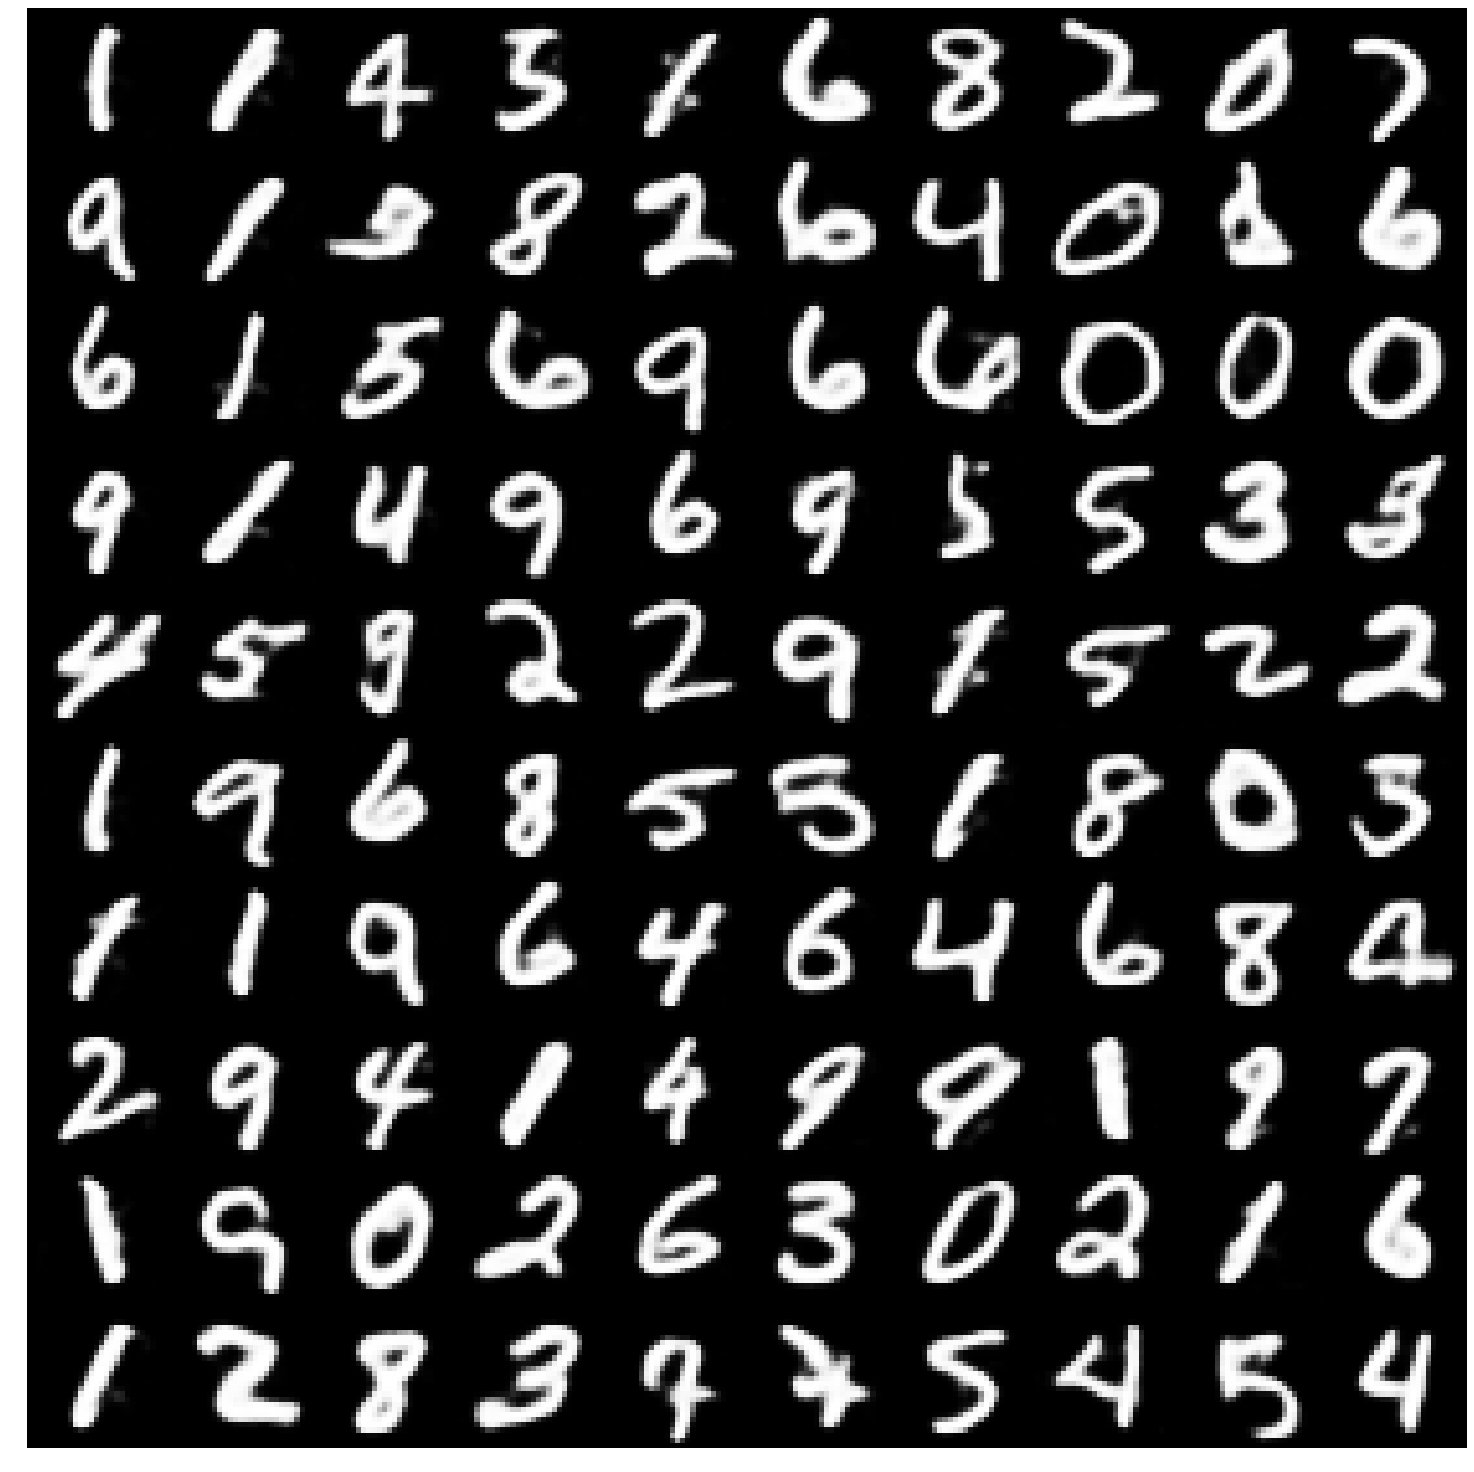

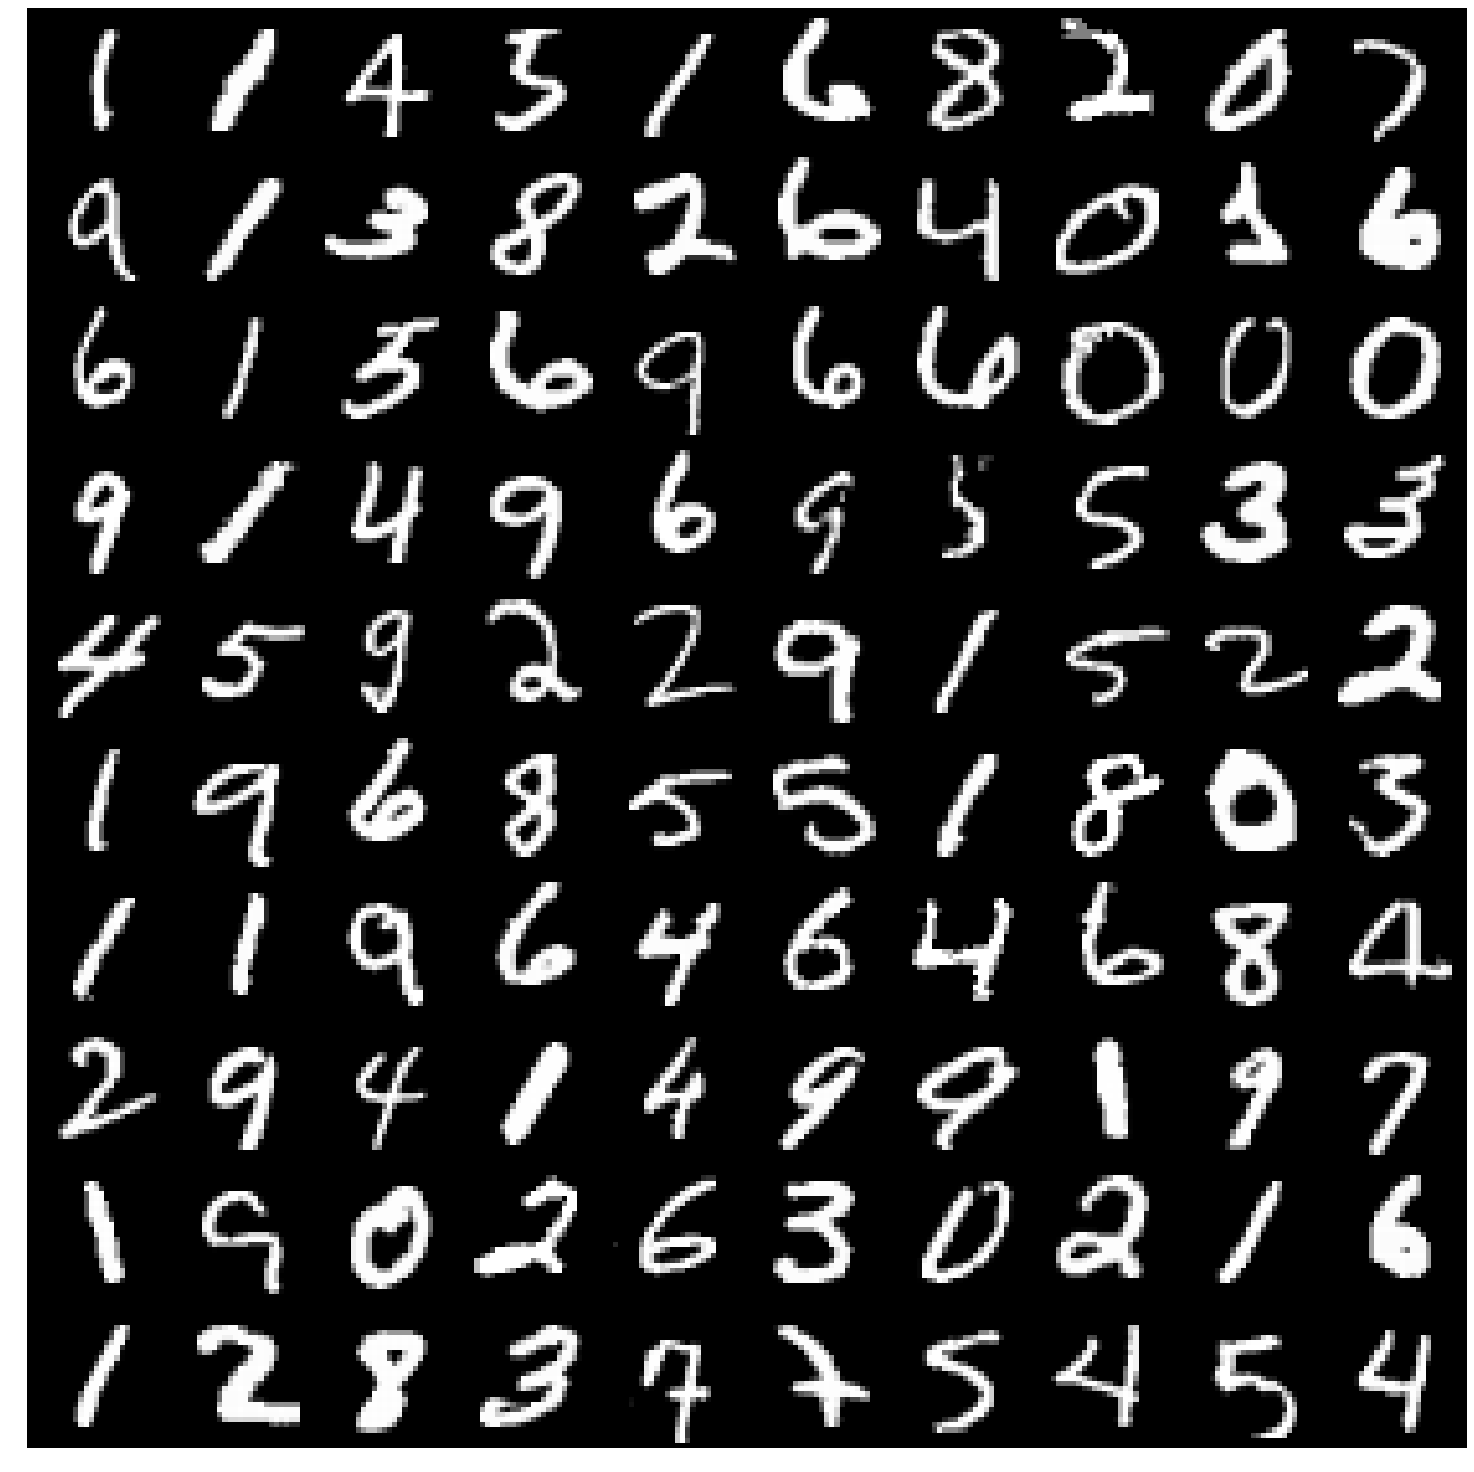

In [10]:
X_test=mnist.test.images
X_test=np.reshape(X_test,[len(X_test),image_size,image_size,1])

f1, ax1 = plt.subplots(10, 10, figsize=(20, 20))
f1.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
f2, ax2 = plt.subplots(10, 10, figsize=(20, 20))
f2.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)

for i in range(10):       

    for j in range(10):
        random_test=X_test[np.random.randint(len(X_test))]



        xx=sess.run(x_recon,feed_dict={x:[random_test]})

        ax1[i][j].imshow(np.reshape(xx, (28, 28)) ,cmap='gray')
        ax1[i][j].axis("off")

        ax2[i][j].imshow(np.reshape(random_test, (28, 28)) ,cmap='gray')
        ax2[i][j].axis("off")

plt.show()

# Random Latent Decoded

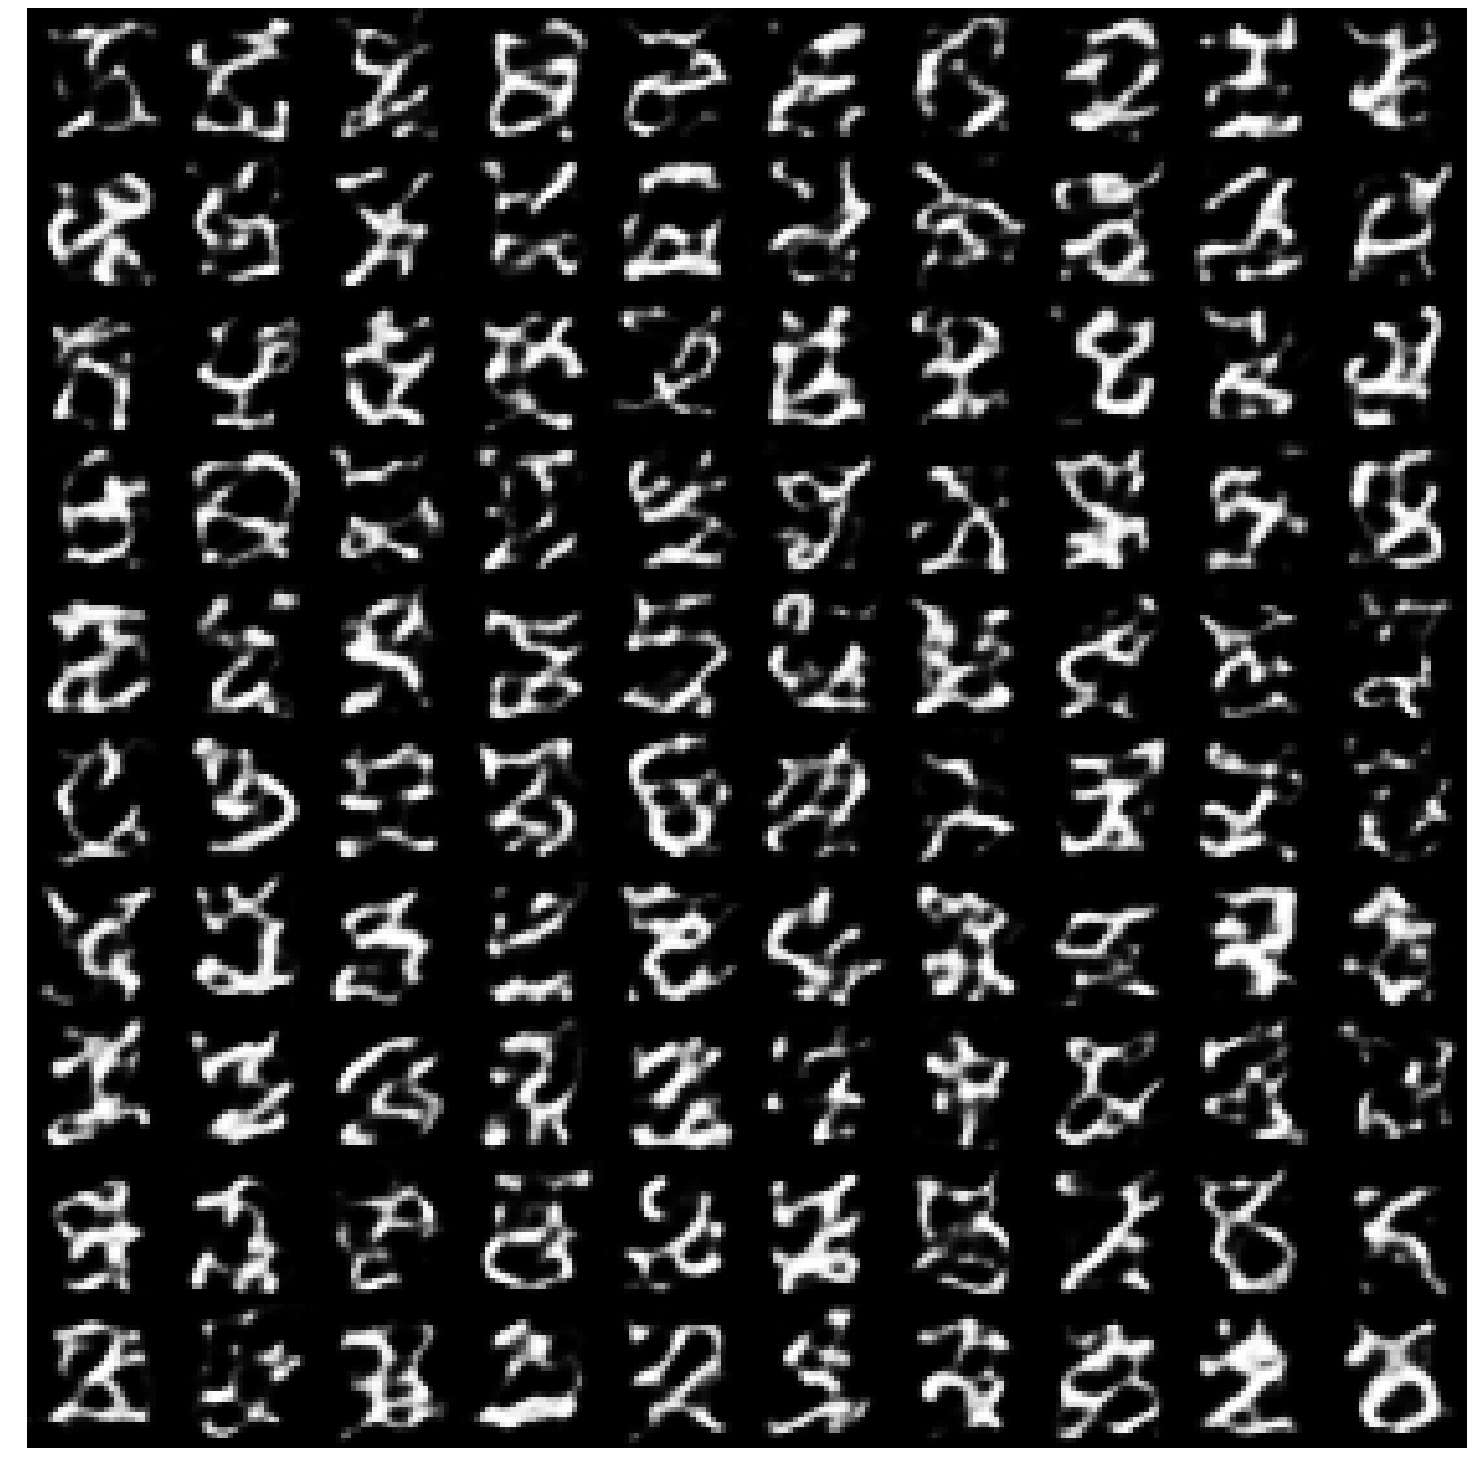

In [11]:
rn_recon=Decoder(rn_zq, False, True)

f, ax = plt.subplots(10, 10, figsize=(20, 20))
f.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)

for i in range(10):       

    for j in range(10):
        random_test=X_test[np.random.randint(len(X_test))]

        xx=sess.run(rn_recon, feed_dict={x:[random_test]})

        xx=np.reshape(xx, [image_size,image_size])

        ax[i][j].imshow(np.reshape(xx, (28, 28)) ,cmap='gray')
        ax[i][j].axis("off")

plt.show()

# Training PixelCNN

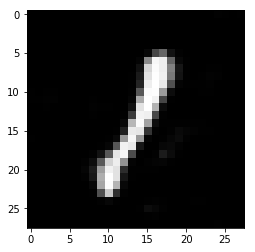

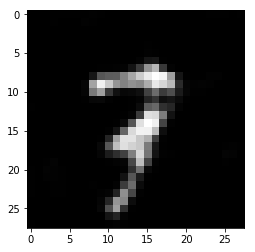

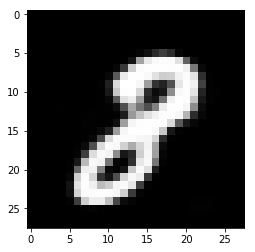

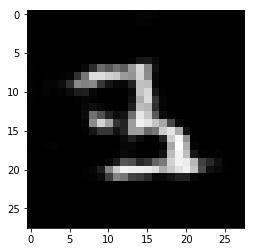

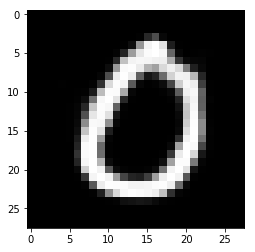

In [12]:
if train_model:

    for i in range(num_epoch_pixel):
        np.random.shuffle(X_train)

        batch_count=0

        for offset in range(0,len_data,batch_size):            
            end=offset+batch_size
            batch_x=X_train[offset:offset+batch_size]
            batch_count+=1

            vq_latent=sess.run(vq_index, feed_dict={x: batch_x, is_training: False})

            sess.run(optimizer_pixelcnn, feed_dict={x: batch_x , pixel_train: vq_latent})

            print ("Batch: {}".format(offset/len_data), end="\r")


        if (i%10)==1:

            sample_pixel=sess.run(pixel, feed_dict={pixel_train: vq_latent})

            pixel_re=sess.run(pixel_recon, feed_dict={x:batch_x, 
                                            pixelcnn_sample: sample_pixel["sampled_pixelcnn"]})

            pixel_re=(pixel_re+1.0)/2

            pixel_re=np.reshape(pixel_re, [-1,image_size,image_size])
            
            plt.imshow(pixel_re[0], cmap='gray')
            plt.show()
            

# PixelCNN Trained Latent Decoded

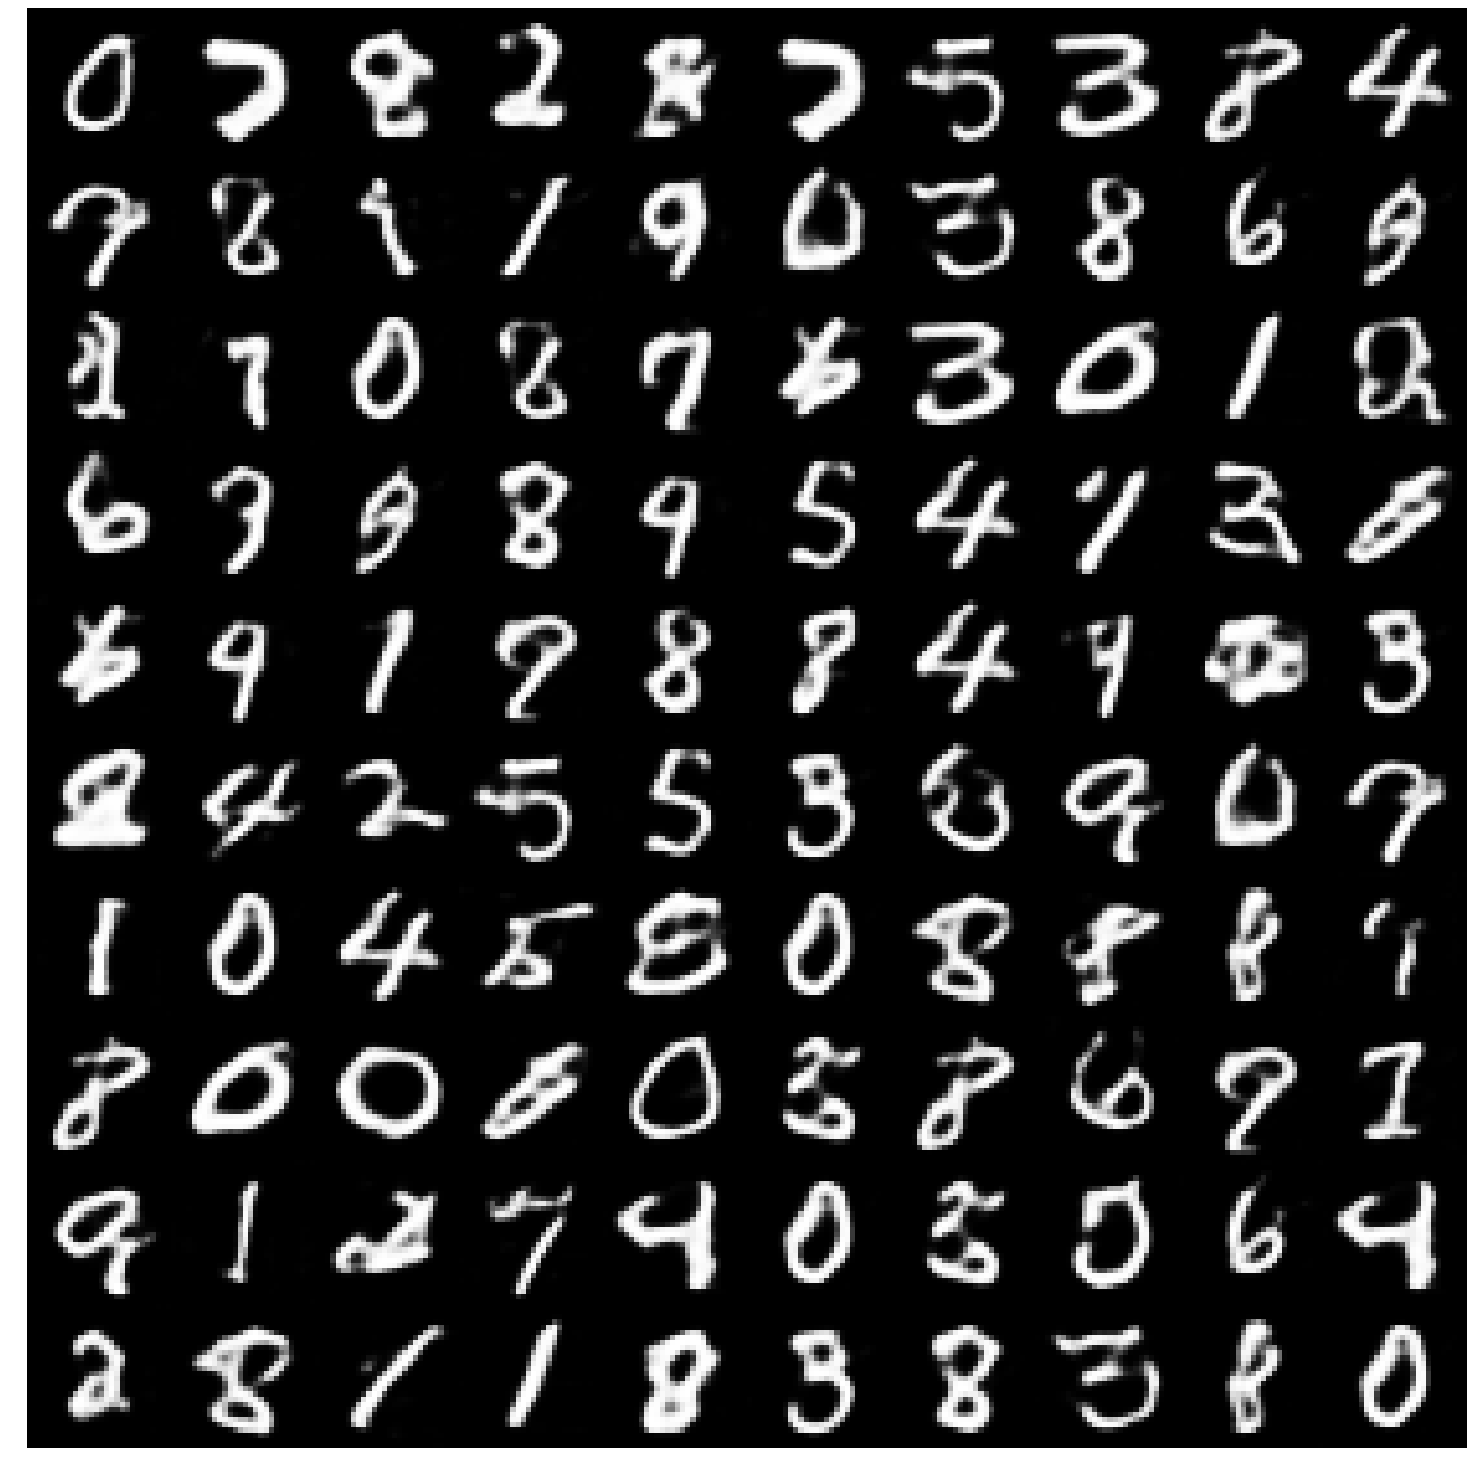

In [13]:
X_test=mnist.test.images
X_test=np.reshape(X_test,[len(X_test),image_size,image_size,1])
        
f, ax = plt.subplots(10, 10, figsize=(20, 20))
f.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)

sample_pixel=sess.run(pixel, feed_dict={pixel_train: vq_latent})
pixel_re=sess.run(pixel_recon, feed_dict={x:[random_test],
                                    pixelcnn_sample: sample_pixel["sampled_pixelcnn"]})
xx=np.reshape(pixel_re, [-1,image_size,image_size])

for i in range(10):       

    for j in range(10):

        ax[i][j].imshow(xx[np.random.randint((100))] ,cmap='gray')
        ax[i][j].axis("off")

plt.show()